In [3]:
%load_ext autoreload
%autoreload 2

In [21]:
import wfdb
import requests, zipfile, io
import pandas as pd
import ast
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from plot import plot_ax, plot_12,lead_index
import tensorflow_addons as tfa
import math
from zlib import crc32
import os
from tqdm import tqdm
from data import gen_df,gen_datasets
from vit import VisionTransformer
from sklearn.utils import compute_class_weight


In [ ]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [5]:
root = Path("/data/")
data_path = Path(root/"a-large-scale-12-lead-electrocardiogram-database-for-arrhythmia-study-1.0.0")

In [ ]:
# download dataset
r = requests.get("https://physionet.org/static/published-projects/ecg-arrhythmia/a-large-scale-12-lead-electrocardiogram-database-for-arrhythmia-study-1.0.0.zip")
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall(root)

In [6]:
df = gen_df(data_path)

100%|██████████| 45152/45152 [02:20<00:00, 321.92it/s]


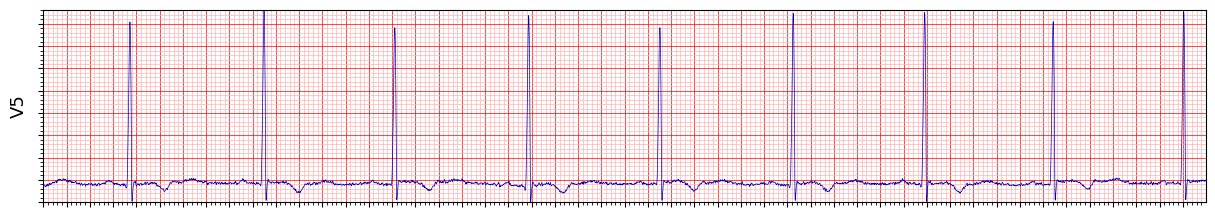

In [26]:
file = df[df["y"].apply(lambda x: x.sum()==2)].values[3]
record = wfdb.rdrecord(data_path/file[0])
# fig,ax = plot_12(record.p_signal,record.fs,plot_grid=False)
fig,ax = plt.subplots(1,1,figsize=(15,2.5))
plot_ax(ax,record.p_signal[:,10],record.fs,plot_grid=True)
ax.set_ylabel(lead_index[10], fontsize=13)
fig.savefig("lvhV5.png")

In [21]:
df["file"].values[0]

'/data/a-large-scale-12-lead-electrocardiogram-database-for-arrhythmia-study-1.0.0/WFDBRecords/40/405/JS39991'

In [4]:
record = wfdb.rdrecord("/data/a-large-scale-12-lead-electrocardiogram-database-for-arrhythmia-study-1.0.0/WFDBRecords/40/405/JS39991")

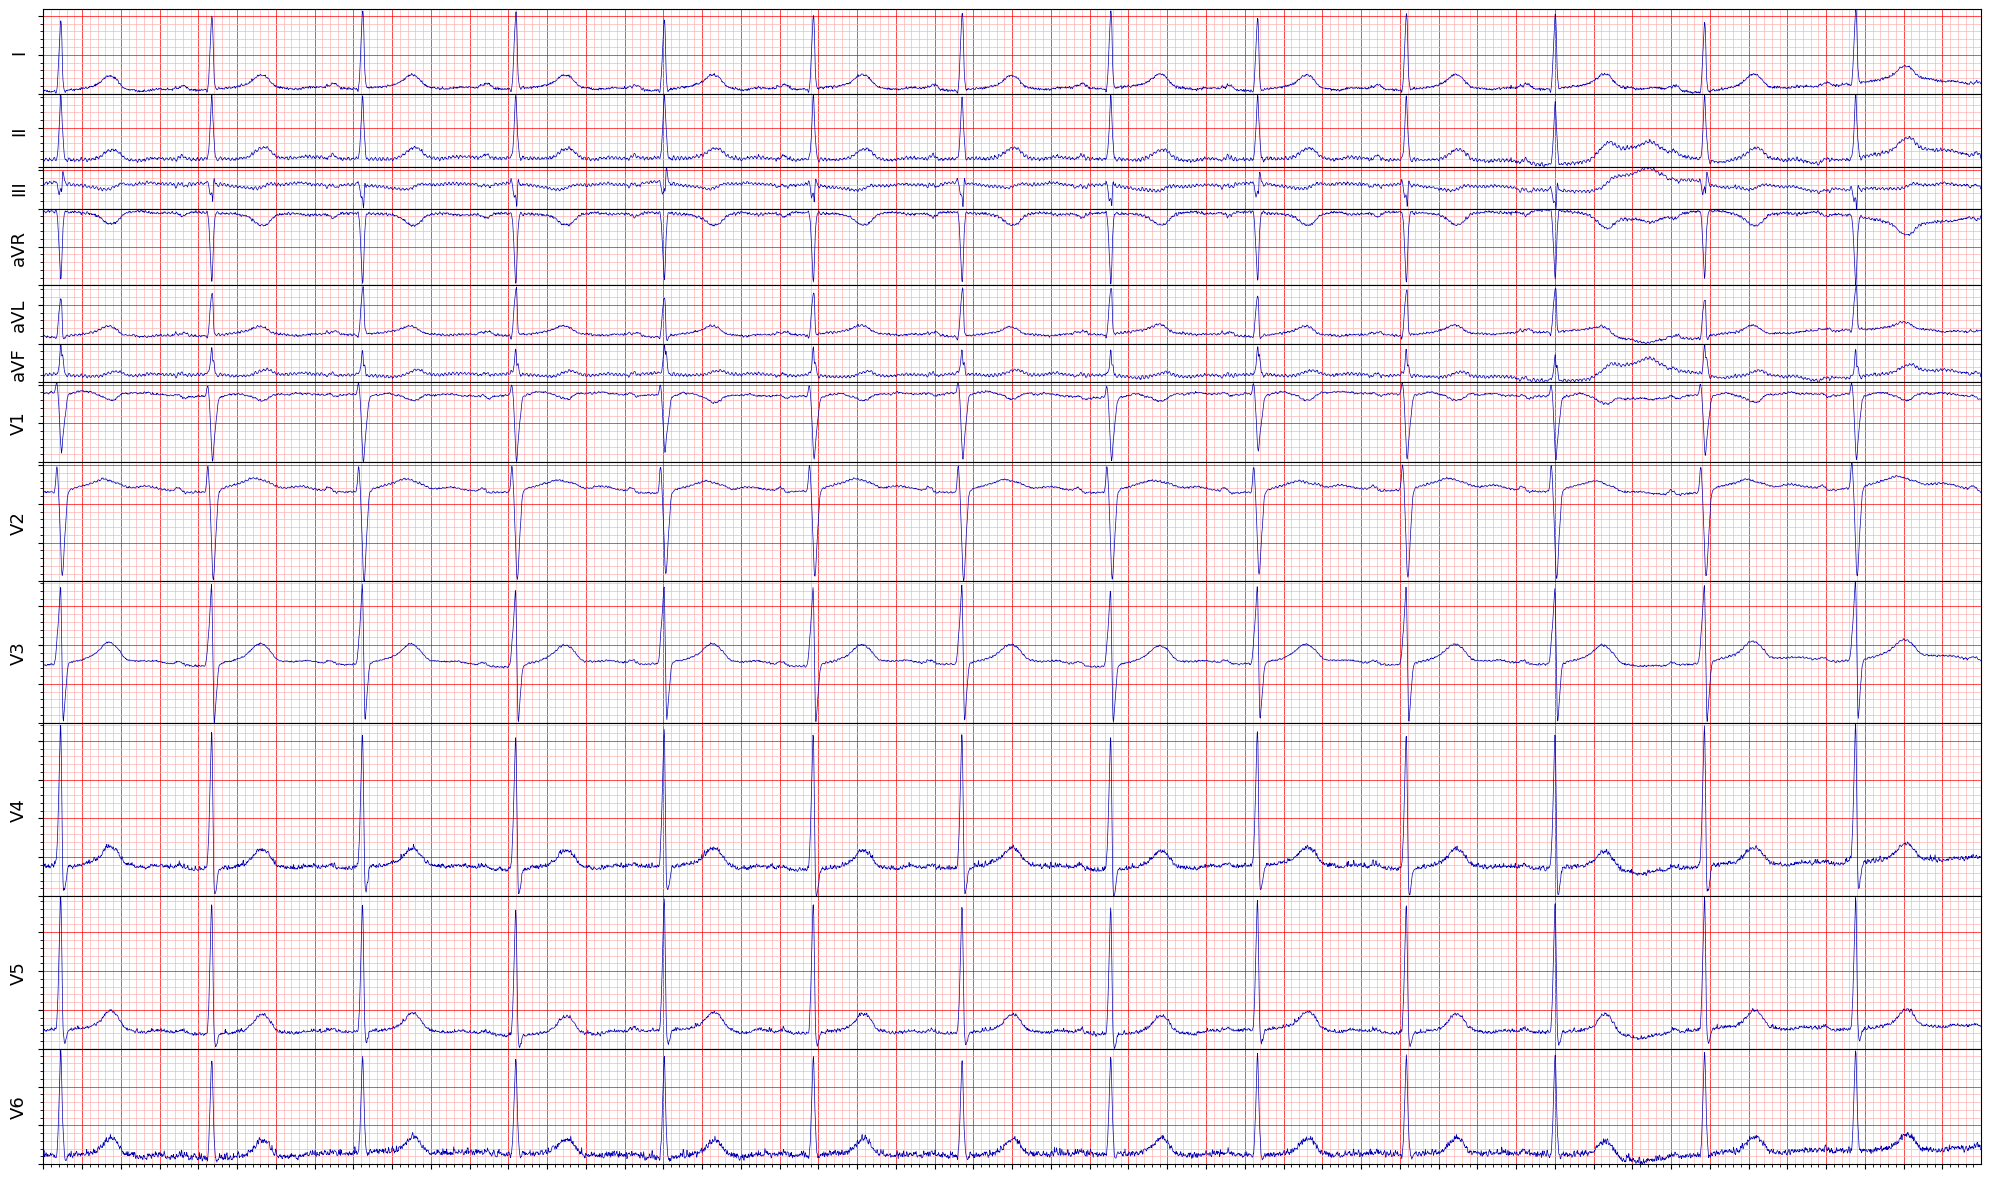

In [11]:
fig,ax = plot_12(record.p_signal,record.fs)
fig.savefig("ecg12.png")

In [5]:
labels = [59931005, 164873001]
code2name = dict(pd.read_csv(data_path/"ConditionNames_SNOMED-CT.csv")[["Snomed_CT","Acronym Name"]].values)
labels_index = {snomed:i for i,snomed in enumerate(labels)}
index2name = {v:code2name[k] for k,v in labels_index.items()}

In [11]:
print(sorted({index2name[i]:count for i,count in enumerate(sum(df["y"]))}.items(),key=lambda kv:kv[1],reverse=True)[:20])

[('TWC', 7043.0), ('TWO', 2877.0), ('STDD', 1668.0), ('STTC', 1158.0), ('AQW', 1063.0), ('LVH', 647.0)]


In [ ]:
fig,axs = plot_12(wfdb.rdrecord(df["file"].values[1]).p_signal,500,plot_grid=True)

In [4]:
vit = VisionTransformer(patch_size=20, hidden_size=768, depth=6, num_heads=6, mlp_dim=256, num_classes=2)
vit.load_weights("/data/vit_best/")

2023-01-15 15:34:37.720586: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-15 15:34:37.725195: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-15 15:34:37.726158: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-15 15:34:37.727353: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [7]:
df_test = df[df["test"]].copy()

In [109]:
#[59931005, 164873001]
dx = 59931005

p = df_test#[df_test["y"].apply(lambda x: x[labels_index[dx]]==1)]
p["dx"] = df_test["y"].apply(lambda x: x[labels_index[dx]])
p = p[p["dx"]==1]
#p = p.sort_values("dx",ascending=False)

#record = wfdb.rdrecord(p["file"].values[21])
record = wfdb.rdrecord(p["file"].values[21])
print(record.comments)
tf.sigmoid(vit.predict(tf.expand_dims(record.p_signal,0)))

['Age: 42', 'Sex: Female', 'Dx: 426177001,164934002,59931005', 'Rx: Unknown', 'Hx: Unknown', 'Sx: Unknown']
1/1 [==============================] - 0s 23ms/step


<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.07729705, 0.00036333]], dtype=float32)>

In [118]:
p["file"].values[21]

'/data/a-large-scale-12-lead-electrocardiogram-database-for-arrhythmia-study-1.0.0/WFDBRecords/06/066/JS05865'

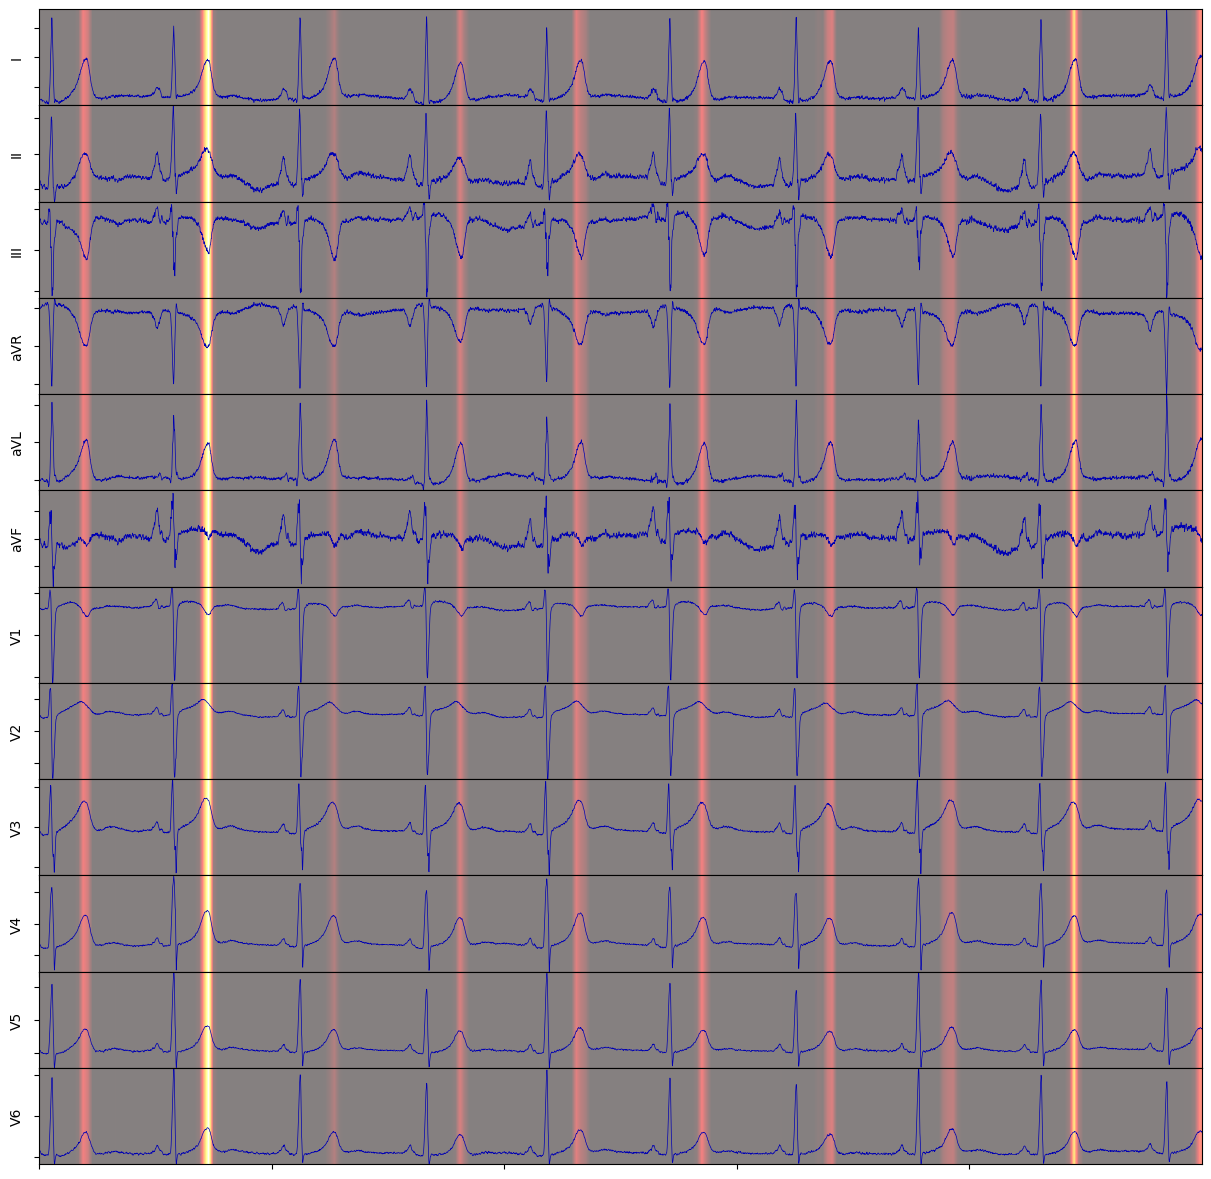

In [115]:
attn = vit.get_last_selfattention(tf.expand_dims(record.p_signal,0))
attn = attn[0,:,0,1:] # cls_token attention with rest 
attn = tf.transpose(attn,(1,0))
attn = tf.expand_dims(tf.expand_dims(attn,0),0)
attn = tf.image.resize(attn,(1,5000))

head = 4
fig,axs = plot_12(record.p_signal,500,plot_grid=False)
for i,ax in enumerate(axs):
    ax.pcolorfast(ax.get_xlim(), ax.get_ylim(),attn[0,0,:,head][np.newaxis],cmap="hot",alpha=0.5)